# DAY 3: Generalization and Uncertainty


### Machine Learning and Computational Statistics (DSC6232) 
#### Instructors: Weiwei Pan, Melanie Fernandez, Pavlos Protopapas 
#### Due: July 26th, 2:00 pm Kigali Time


**First name**: _________________________________________________________


**Last name**: _____________


## Learning Goals:

1. explore the concept of high-variance: why is it a problem?
2. understand confidence intervals and predictive intervals
3. understand regularization using Ridge and Lasso regression
4. understand bagging: training an ensemble of models

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso

### We include helper functions here that we will need later (no need to read in detail!)

In [18]:
def make_data(number_of_points, f):
    '''
    This function randomly samples training data in [-5, 5], given a function f.
    
    number_of_points: number of points to sample
    f: the underlying function relating x and y
    '''
    #randomly sample training inputs from [-5, 5]
    x = np.random.uniform(-5, 5, number_of_points)
    #sort the randomly sampled training inputs
    x = np.sort(x)
    #generate noisy training labels for the sampled training inputs
    y = f(x) + np.random.normal(0, 0.5, number_of_points)
    return x, y

def fit_polynomial_regression(x_train, y_train, x_test, polynomial_features, regression):
    '''
    This function implements polynomial regression, given training and testing data as well as
    a polynomial feature model and a linear regression model.
    
    x_train: training inputs
    y_train: training labels
    x_test: tests inputs
    polynomial_features: model for transforming inputs into polynomial features
    regression: linear regression model
    '''
    #tranform training inputs into polynomial features
    poly_x_train = polynomial_features.fit_transform(x_train.reshape((-1, 1)))
    #tranform testing inputs into polynomial features
    poly_x_test = polynomial_features.transform(x_test.reshape((-1, 1)))
    #fit linear regression on top of polynomial features
    regression.fit(poly_x_train, y_train)
    #predict labels for test input
    y_predict = regression.predict(poly_x_test)
    return regression, y_predict

## 1. The Effects of High-Variance

In this section, we explore the properties of models that have high variance.

Let's generate some very noisy data using a simple cubic function $f(x) = 0.01 x^3$.

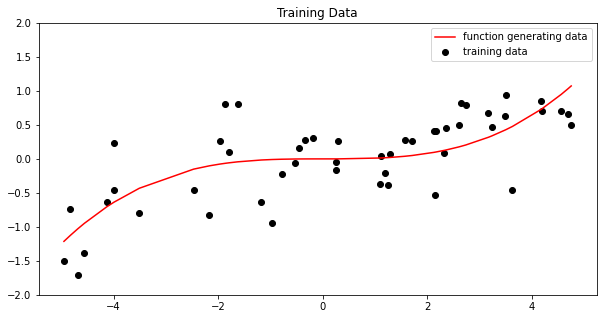

In [19]:
#number of training inputs
number_of_train_points = 50
#number of testing inputs
number_of_test_points = 100
#function generating our data
f = lambda x: 0.01 * x**3

#make training data
x_train, y_train = make_data(number_of_train_points, f)
#make test input that is evenly spaced over [-5, 5]
x_test = np.linspace(-5, 5, number_of_test_points)

#visualize training data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#plot training data
ax.scatter(x_train, y_train, color='black', label='training data')
#plot the underlying function generating the data
ax.plot(x_train, f(x_train), color='red', label='function generating data')
ax.set_title('Training Data')
ax.set_ylim([-2, 2])
plt.legend(loc='best')
plt.show()

Now, let's fit polynomial regression models with different degrees to our training data. Higher polynomial degree means that the model can learn more complicated functions (more flexible). In the code below, we train the same model twice with slightly different data (resampled from the true generating function).

**Exercise 1:**  Try training polynomial regression models with different degrees (some very low, e.g. degree=2, some very high, e.g. degree=20) - you need to change the degree in our code and experiment! Which type of polynomial model changes the most when we resample the training data? Which type of polynomial changes the least when we resample the training data?

Why is this happening? Support your answers with concepts you've learned from lecture. 

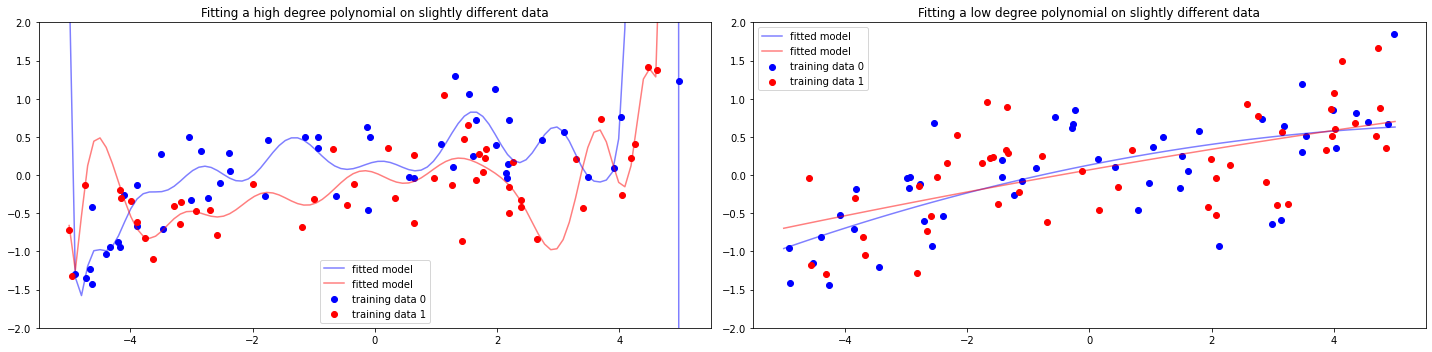

In [20]:
#instantiate a polynomial feature model for a degree 20 polynomial
polynomial_features_high = PolynomialFeatures(20)
#instantiate a polynomial feature model for a degree 2 polynomial
polynomial_features_low = PolynomialFeatures(2)
#instantiate a linear regression model
regression = LinearRegression(fit_intercept=False)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
colors = ['blue', 'red']

#fit polynomial models on random samples of training sets
for i in range(2):
    #resample training data
    x_train, y_train = make_data(number_of_train_points, f)
    #fit our polynomial model on the resampled data
    trained_regressor, y_predict = fit_polynomial_regression(x_train, y_train, x_test, polynomial_features_high, regression)
    #plot the resampled training data
    ax[0].scatter(x_train, y_train, color=colors[i], label='training data {}'.format(i))
    #plot the fitted polynomial model
    ax[0].plot(x_test, y_predict, color=colors[i], alpha=0.5, label='fitted model')
    
ax[0].set_title('Fitting a high degree polynomial on slightly different data')
ax[0].set_ylim([-2, 2])
ax[0].legend(loc='best')

# fit low degree polynomial models
for i in range(2):
    #resample training data
    x_train, y_train = make_data(number_of_train_points, f)
    #fit our polynomial model on the resampled data
    trained_regressor, y_predict = fit_polynomial_regression(x_train, y_train, x_test, polynomial_features_low, regression)
    #plot the resampled training data
    ax[1].scatter(x_train, y_train, color=colors[i], label='training data {}'.format(i))
    #plot the fitted polynomial model
    ax[1].plot(x_test, y_predict, color=colors[i], alpha=0.5, label='fitted model')
    
ax[1].set_title('Fitting a low degree polynomial on slightly different data')
ax[1].set_ylim([-2, 2])
ax[1].legend(loc='best')


plt.tight_layout()
plt.show()

**Exercise 2:** Which polynomial degree will yield the biggest difference in training and test MSE (you can either compute the training and test MSE or just reason about it), i.e. which model will overfit? Why?

Is is a good idea to fit a degree 20 polynomial on this dataset? Why or why not? Support your answer with concepts you'ved learned in lecture.

**Exercise 3:** Generate 100 random samples of training data. Use this to compute the 95% confidence intervals for the coefficients of the degree 20 polynomial model and plot them as box plots. Compute the 95% confidence intervals for the coefficients of the degree 2 polynomial model and plot them as box plots. 

Of the coefficients in the degree 20 polynomial model, which coefficients are we more certain about? Which ones are we less certain about?

Overall, for which model are we more certain about the coefficients?

Is this result what you expect? Support your answer using concepts you've learned in lecture.

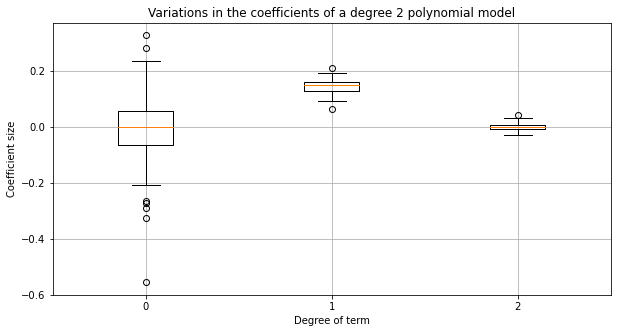

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
coefficients = [] # use this list to keep tract of the coefficients
S = 100 # number of randomly sampled training data
for i in range(S):
    # resample training data
    x_train, y_train = make_data(number_of_train_points, f)
    # fit our polynomial model on the resampled data
    trained_regressor, y_predict = fit_polynomial_regression(x_train, y_train, x_test, polynomial_features_low, regression)
    # add the coefficients of the trained model to our list
    coefficients.append(trained_regressor.coef_)
# turn the list of coefficients into a numpy array
coefficients = np.array(coefficients)
# make box plots for each coefficient
ax.boxplot(coefficients)

ax.set_xticklabels([0, 1, 2])
ax.grid()
ax.set_title('Variations in the coefficients of a degree 2 polynomial model')
ax.set_xlabel('Degree of term')
ax.set_ylabel('Coefficient size')
plt.show()

**Exercise 4**: Based on the confidence intervals of the model coefficients, which model will produce the most undertain predictions (i.e. have the widest prediction interval)? Why? You can answer this question by computing the 95% prediction interval or you can reason about the answer.

## 2. Regularization
In the following we will implement Ridge ($\ell_2$ regularization) regression, and observe the effect of regularization on variance reduction.

**Exercise 5:** repeat the experiment in **Exercise 1** for a degree 20 polynomial using Ridge regression. You should try different choices for the regularization parameter `alpha`. 

Visualize the Ridge polynomial regression model and discuss the impact of regularization on the fitted model.

C:\Users\krosenfeld\Documents\projects\other\Rwanda-Data-Science-NBs\envs\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.7338e-29): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\krosenfeld\Documents\projects\other\Rwanda-Data-Science-NBs\envs\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.61229e-29): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


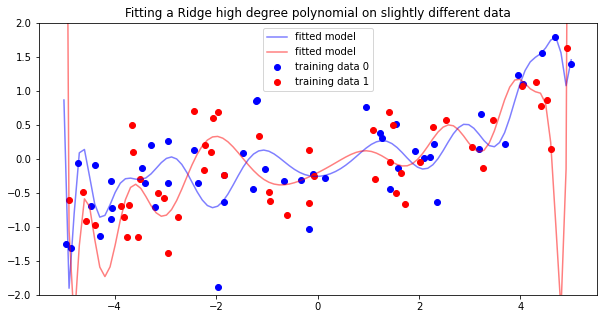

In [25]:
# Step 0: instantiate a polynomial feature model for a degree 20 polynomial
polynomial_features_high = PolynomialFeatures(20)

# Step 1: instantiate a RidgeRegreession model
# Hint: see documentation https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
# Remember to set fit_intercept=False
ridge_regression = Ridge(fit_intercept=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
colors = ['blue', 'red']

# Step 2: fit polynomial models on random samples of training sets
for i in range(2):
    #resample training data
    x_train, y_train = make_data(number_of_train_points, f)

    #fit our polynomial model on the resampled data
    trained_regressor, y_predict = fit_polynomial_regression(x_train, y_train, x_test, polynomial_features_high, ridge_regression)

    #plot the resampled training data
    ax.scatter(x_train, y_train, color=colors[i], label='training data {}'.format(i))

    #plot the fitted polynomial model
    ax.plot(x_test, y_predict, color=colors[i], alpha=0.5, label='fitted model')
    
ax.set_title('Fitting a Ridge high degree polynomial on slightly different data')
ax.set_ylim([-2, 2])
ax.legend(loc='best')

plt.show()

**Question**: What is the effect of regularization on this model's variance? Compare Ridge and Lasso regression: what differences do you observe? 

C:\Users\krosenfeld\Documents\projects\other\Rwanda-Data-Science-NBs\envs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.690157277495499, tolerance: 0.002180429010201712
  model = cd_fast.enet_coordinate_descent(
C:\Users\krosenfeld\Documents\projects\other\Rwanda-Data-Science-NBs\envs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3102531343353485, tolerance: 0.0023528719858761423
  model = cd_fast.enet_coordinate_descent(


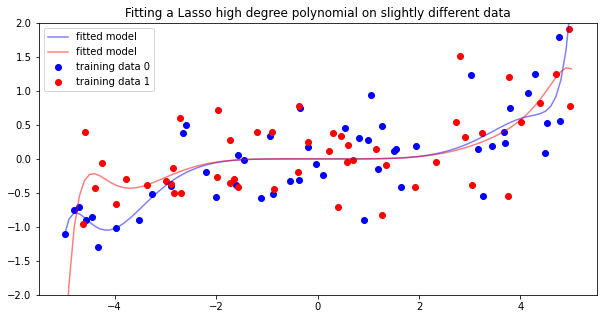

In [24]:
# Step 0: instantiate a polynomial feature model for a degree 20 polynomial
polynomial_features_high = PolynomialFeatures(20)

# Step 1: instantiate a RidgeRegreession model
# Hint: see documentation https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
# Remember to set fit_intercept=False
lasso_regression = Lasso(fit_intercept=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
colors = ['blue', 'red']

# Step 2: fit polynomial models on random samples of training sets
for i in range(2):
    #resample training data
    x_train, y_train = make_data(number_of_train_points, f)

    #fit our polynomial model on the resampled data
    trained_regressor, y_predict = fit_polynomial_regression(x_train, y_train, x_test, polynomial_features_high, lasso_regression)

    #plot the resampled training data
    ax.scatter(x_train, y_train, color=colors[i], label='training data {}'.format(i))

    #plot the fitted polynomial model
    ax.plot(x_test, y_predict, color=colors[i], alpha=0.5, label='fitted model')
    
ax.set_title('Fitting a Lasso high degree polynomial on slightly different data')
ax.set_ylim([-2, 2])
ax.legend(loc='best')

plt.show()

## 3. Bagging
In the following we will implement bagging:
1. we will train a large ensemble of complex models on different samples of training data
2. we will average the predictions of the models in our ensemble to reduce the variance in the prediction.

**Exercise 6:** Repeat the experiment above (in Section 1) 100 times: that is, generate randomly sampled training data 100 times and train a degree 20 polynomial on each resampled training data set (this is our "ensemble" of models). To make predictions on the test set, we average the predictions of all the models in our ensemble.

Visualize each model in the ensemble. Visualize also their average.

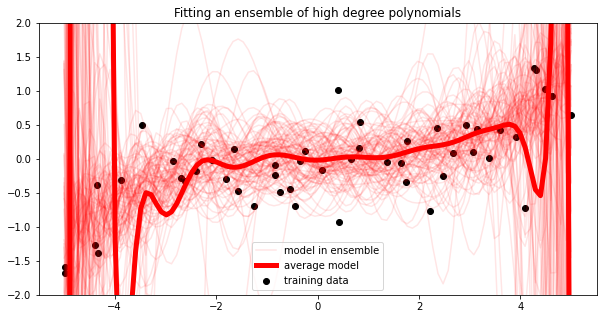

In [28]:
#instantiate a polynomial feature model for a degree 20 polynomial
polynomial_features_high = PolynomialFeatures(20)

#instantiate a linear regression model
regression = LinearRegression(fit_intercept=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_train, y_train, color='black', label='training data') #plot training data

#fit polynomial models on random samples of training sets
S = 100
## Step 1: initialize a list to record all the model predections
predictions = []
for i in range(S):
    #resample training data
    x_train, y_train = make_data(number_of_train_points, f)
    #fit our polynomial model on the resampled data
    trained_regressor, y_predict = fit_polynomial_regression(x_train, y_train, x_test, polynomial_features_high, 
                                                             regression)

    ## Step 2: add new model prediction to list of predictions
    predictions.append(y_predict)

    #plot the fitted polynomial model
    if i == 0:
      ax.plot(x_test, y_predict, color='red', alpha=0.1, label='model in ensemble')
    else:
      ax.plot(x_test, y_predict, color='red', alpha=0.1)

## Step 3: average the list of predictions
y_predict_avg = np.mean(predictions, axis=0)

## Step 4: visualize average predictions
ax.plot(x_test, y_predict_avg, color='red', linewidth=5, alpha=1., label='average model')

ax.set_title('Fitting a high degree polynomial on slightly different data')
ax.set_ylim([-2, 2])
ax.legend(loc='best')

ax.set_title('Fitting an ensemble of high degree polynomials')
ax.set_ylim([-2, 2])
plt.legend(loc='best')
plt.show()

C:\Users\krosenfeld\Documents\projects\other\Rwanda-Data-Science-NBs\envs\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.21444e-29): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\krosenfeld\Documents\projects\other\Rwanda-Data-Science-NBs\envs\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.84203e-28): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\krosenfeld\Documents\projects\other\Rwanda-Data-Science-NBs\envs\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.74484e-29): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\krosenfeld\Documents\projects\other\Rwanda-Data-Science-NBs\envs\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.13216e-28): result may not be accurate.
  return li

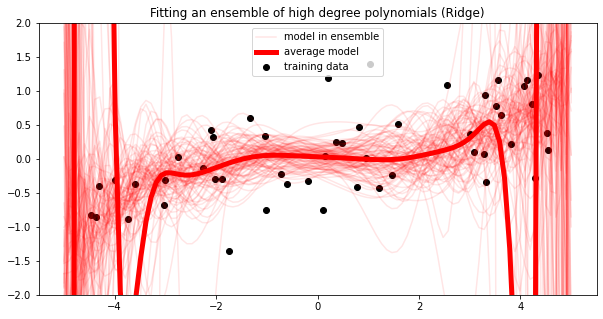

In [32]:
#instantiate a polynomial feature model for a degree 20 polynomial
polynomial_features_high = PolynomialFeatures(20)

#instantiate a linear regression model
regression = Ridge(fit_intercept=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_train, y_train, color='black', label='training data') #plot training data

#fit polynomial models on random samples of training sets
S = 100
## Step 1: initialize a list to record all the model predections
predictions = []
for i in range(S):
    #resample training data
    x_train, y_train = make_data(number_of_train_points, f)
    #fit our polynomial model on the resampled data
    trained_regressor, y_predict = fit_polynomial_regression(x_train, y_train, x_test, polynomial_features_high, 
                                                             regression)

    ## Step 2: add new model prediction to list of predictions
    predictions.append(y_predict)

    #plot the fitted polynomial model
    if i == 0:
      ax.plot(x_test, y_predict, color='red', alpha=0.1, label='model in ensemble')
    else:
      ax.plot(x_test, y_predict, color='red', alpha=0.1)

## Step 3: average the list of predictions
y_predict_avg = np.mean(predictions, axis=0)

## Step 4: visualize average predictions
ax.plot(x_test, y_predict_avg, color='red', linewidth=5, alpha=1., label='average model')

ax.set_title('Fitting a high degree polynomial on slightly different data')
ax.set_ylim([-2, 2])
ax.legend(loc='best')

ax.set_title('Fitting an ensemble of high degree polynomials (Ridge)')
ax.set_ylim([-2, 2])
plt.legend(loc='best')
plt.show()

**Exercise 7:** What do you notice about each of the models in your ensemble? What do you notice about their average? State your answer in terms of variance, uncertainty and other concepts you've learned from lecture.

---
# This section is for Extra Credit, the exercises are optional.
## 4. Bootstrap

In the provided `make_data` function above, we resampled new training inputs from the interval $[-5, 5]$. When we do not have access to new data (e.g. collecting new data is prohibitively expensive), we need to create "new data" from our existing data. To do this, we **bootstrap**, that is, we sample different subsets from our existing data.

**Exercise 8 (Extra Credit):** Adapt the `make_data` function to bootstrap sample from an existing dataset `x`, `y`, and create your ensemble using these bootstrap samples.

In [33]:
def bootstrap_data(number_of_train_points, x, y):
    '''
    This function randomly samples training data from existing data x and y.
    
    number_of_train_points: number of training points to sample
    number_of_test_points: number of testing points to sample
    x: array of existing inputs
    y: array of existing labels 
    f: the underlying function relating x and y
    '''
    # Step 1: randomly select indices in x and y
    # Hint: use the numpy.random.choice to choose a set of indices from 0 to the len(x)
    # https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.choice.html
    random_indices = np.random.choice(len(x), number_of_train_points)
    # 
    # Step 2: select x values using this set of random indices:
    x_train = x[random_indices]
    # Step 3: select y values using this set of random indices:
    y_train = y[random_indices]

    return x_train, y_train

x = np.random.uniform(-5, 5, number_of_train_points)
y = f(x) + np.random.normal(0, 0.5, number_of_train_points)

After filling in the `bootstrap_data` function. Uncomment the following and run the cell.

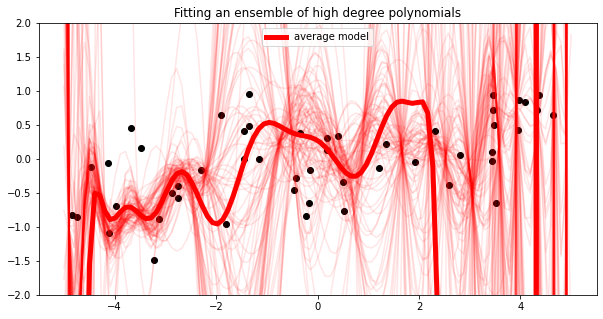

In [34]:
#instantiate a polynomial feature model for a degree 20 polynomial
polynomial_features_high = PolynomialFeatures(20)

#instantiate a linear regression model
regression = LinearRegression(fit_intercept=False) 

# visualize each model in the bootstrap ensemble and visualize their average
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_train, y_train, color='black') #visualize the training set

y_average_predict = 0
ensemble_size = 100
for i in range(ensemble_size):
    #resample training data
    x_train, y_train = bootstrap_data(number_of_train_points, x, y)
    #fit our polynomial model on the resampled data
    _, y_predict = fit_polynomial_regression(x_train, y_train, x_test, polynomial_features_high, regression)
    #add the prediction of the new model to the predictions of the previous models
    y_average_predict += y_predict
    #plot the function learned for the resampled training data
    ax.plot(x_test, y_predict, color='red', alpha=0.1)

#average the predictions of the models
y_average_predict /= ensemble_size * 1.

#plot the averaged model
ax.plot(x_test, y_average_predict, linewidth=5, color='red', label='average model')
ax.legend(loc='best')
ax.set_title('Fitting an ensemble of high degree polynomials')
ax.set_ylim([-2, 2])
plt.show()

**Exercise 9 (Extra Credit)**: What is the difference between building your ensemble from training data resampled from $[-5, 5]$ and training data bootstraped samples from an existing data set $x, y$? Is this what you expect?